In [1]:
!pip install wordcloud --quiet
import json
import re
from spacy import load as spacyload
import glob
from string import punctuation
from tqdm import tqdm
from wordcloud import WordCloud
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def tokenize(doc, lemmatized=False, remove_stopword=False,
                   remove_punct = True, pos_tag = False, remove_num=False):
    nlp=spacyload("en_core_web_sm")
    doc=nlp(doc.lower().strip())

    tokens=[]

    for token in doc:
        if (remove_stopword and token.is_stop) or (token.text=='') or (token.text.isspace()) or (remove_num and token.text.isnumeric()):
            continue

        token_ls=token.text

        if lemmatized:
            token_ls=token.lemma_
        if pos_tag:
            token_ls=(token_ls, token.pos_)

        if remove_punct:
            if token.is_punct:
                continue
            token_no_punct=''
            for character in token_ls:
                if character not in punctuation:
                    token_no_punct+=character
                else:
                    token_no_punct+=' '
            for tok in token_no_punct.split(' '):
                tokens.append(tok)
        else:
            tokens.append(token_ls)
    return tokens


In [3]:
file_list=glob.glob('./patent-recommender/dataset/*.json')
df=pd.DataFrame.from_dict(json.load(open(file_list[0])), orient="index").T
for patent_loc in file_list[1:]:
    patent_file=json.load(open(patent_loc))
    temp_df=pd.DataFrame.from_dict(patent_file, orient="index").T
    df=pd.concat([df, temp_df], ignore_index=True)

In [4]:
df.head(1)

,patent_id,title,assignee,publication_date,patent_link,inventors,classifications,abstract,claims
0,US-10902214-B2,Natural language generation using pinned text ...,"Jungle Disk, L.L.C.",2021-01-26,https://patents.google.com/patent/US10902214B2/en,[Michael DeFelice],"[G06F40/56, G06F40/30, G06F40/211, G06N3/044, ...",A personality model is created for a populatio...,\n1. A method for maintaining a specific seman...


In [5]:
df['claim_list'] = df['claims'].apply(lambda claims: [ claim.replace("\n", " ")for claim in re.split(r"[0-9]+\.", claims) if claim!=''])

In [6]:
df['num_claim']=df['claim_list'].apply(len)
df['num_categories']=df['classifications'].apply(len)
df['publication_date']= pd.to_datetime(df['publication_date'])
df['publication_year']=df['publication_date'].apply(lambda k: k.year)

In [7]:
avg_num_lines=[]
stats_num_lines={}
for claims in df['claim_list']:
    num_lines={}
    for claim in claims:
        length=len([sentence for sentence in claim.split('.') if sentence!=''])
        if length in num_lines:
            num_lines[length]+=1
        else:
            num_lines[length]=1
        if length in stats_num_lines:
            stats_num_lines[length]+=1
        else:
            stats_num_lines[length]=1

    if len(num_lines)==0:
        continue

    avg_num_lines.append(sum([i*j for i, j in num_lines.items()])/sum(num_lines.values()))

print(f"The average number of lines: {sum(avg_num_lines)/len(avg_num_lines):.2f}")
for key, value in sorted(stats_num_lines.items(), key= lambda k:k[0]):
    print(f"Frequency of {key:2} line(s) in a claim is: {value}")

The average number of lines: 1.90
Frequency of  1 line(s) in a claim is: 1816
Frequency of  2 line(s) in a claim is: 13840
Frequency of  3 line(s) in a claim is: 6
Frequency of  4 line(s) in a claim is: 6
Frequency of  5 line(s) in a claim is: 3
Frequency of  6 line(s) in a claim is: 1
Frequency of  7 line(s) in a claim is: 3
Frequency of  8 line(s) in a claim is: 4
Frequency of  9 line(s) in a claim is: 1
Frequency of 10 line(s) in a claim is: 2
Frequency of 11 line(s) in a claim is: 5
Frequency of 12 line(s) in a claim is: 7
Frequency of 14 line(s) in a claim is: 7
Frequency of 15 line(s) in a claim is: 1
Frequency of 17 line(s) in a claim is: 4
Frequency of 21 line(s) in a claim is: 1


In [8]:
print(f"Mean number of claims in a patent: {df['num_claim'].mean():.2f}")
print(f"Mean number of categories in a patent: {df['num_categories'].mean():.2f}")

Mean number of claims in a patent: 21.31
Mean number of categories in a patent: 19.77


<Axes: title={'center': '# of publications vs Publication Year'}, xlabel='Publication Year', ylabel='# of publications'>

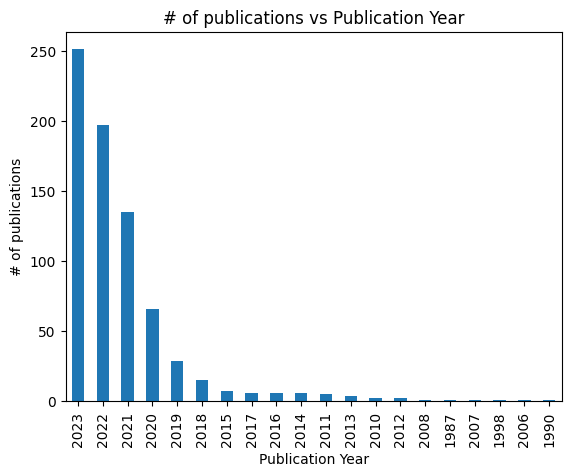

In [9]:
df.publication_year.value_counts().plot(kind='bar',
        title="# of publications vs Publication Year",
        xlabel="Publication Year", ylabel="# of publications")

<Axes: title={'center': 'Top 20 Assignees'}, xlabel='# of assignees'>

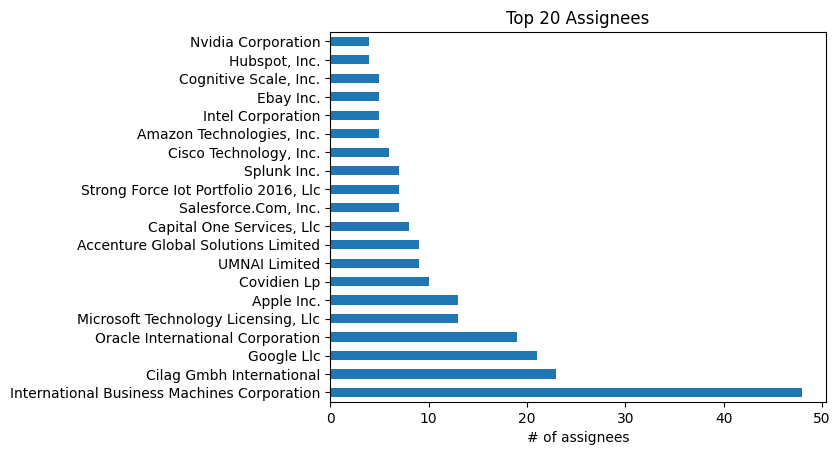

In [10]:
df['assignee'].value_counts().sort_values(ascending=False)[:20].plot(kind="barh",
        title="Top 20 Assignees", xlabel="# of assignees")

In [11]:
tqdm.pandas()

df['claims_tokens']=df['claim_list'].progress_apply(lambda claims: \
 [tokenize(doc=claim, lemmatized=True, remove_punct=True, remove_stopword=True, remove_num=True) \
 for claim in claims])

100%|██████████| 737/737 [2:08:47<00:00, 10.48s/it]


In [15]:
all_words=''
removed_words=['include', 'claim', 'comprise', 'base', 'second']
for claims in df["claims_tokens"]:
    for claim in claims:
        claim=[ word for word in claim if word not in removed_words]
        all_words+=' '.join(claim)

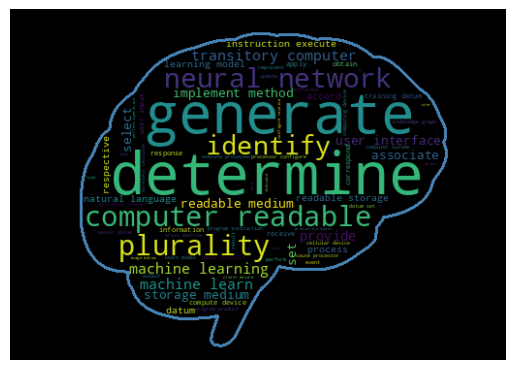

<Figure size 640x480 with 0 Axes>

In [16]:
mask = np.array(Image.open("./6102d59ba849c40004f9a120.png"))
wc = WordCloud(mask=mask, contour_width=2, contour_color='steelblue')
wc.generate(all_words)
wc.to_file("wordcloud.png")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()

In [17]:
df[['patent_id','claims_tokens']].to_csv("compiled.csv")